# Comparing MAGeT ans SUIT results
## Data: 
    - 1. Cerebellar SUIT segmentation; 
         - SUIT: Left/right 1-X+Dentate+Interposed+Fastigial and Vermis
    - 2. Cerebellar MAGeTBrain [MAGeTBrain pipeline](https://github.com/CobraLab/documentation/wiki/MAGeTBrain#collecting-volumes)
        - MAGeT: Left/right 1-X+WhiteMatter(CM)
          maget_df.columns=
          ['L_I_II', 'L_III', 'L_IV', 'L_V', 'L_VI', 'L_Crus_I', 'L_Crus_II', 'L_VIIB', 'L_VIIIA', 'L_VIIIB', 'L_IX', 'L_X', 'L_CM', 
           'R_I_II', 'R_III', 'R_IV', 'R_V', 'R_VI', 'R_Crus_I', 'R_Crus_II', 'R_VIIB', 'R_VIIIA', 'R_VIIIB', 'R_IX', 'R_X', 'R_CM']
          No vermis in MAGeT as well.
## Cohorts
- The augmented cohort 211: MNI ET/ matched NC (34/177).

## Tasks: GLM for 
 - Compare MAGeT and SUIT results correlation;
 - Compare MAGeT and SUIT results in GLM; 

## Covariates
- Age, Sex, intracranial volume (eTIV/cerebellar volume), cohort.

In [1]:
#reading/merging/selecting data
from pathlib import Path
import nipype.interfaces.io as nio
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data_dir = Path("/codes/tab_data")
# data files
matched_des_all_file = data_dir/ 'matched_Des-all_qced.csv'
matched_DKT_all_file = data_dir/ 'matched_DKT-all_qced.csv'

data_df = pd.read_csv(matched_des_all_file , sep=',', header=0, index_col=0);

In [2]:
#GLM analysis and non-parametric comparison
SUIT_l_labels = ['Left_I_IV',  'Left_V', 'Left_VI', 'Left_CrusI', 'Left_CrusII', 
                 'Left_VIIb', 'Left_VIIIa', 'Left_VIIIb', 'Left_IX', 'Left_X', 
                 'Left_Dentate', 'Left_Interposed', 'Left_Fastigial'];
SUIT_r_labels = ['Right_I_IV','Right_V','Right_VI','Right_CrusI','Right_CrusII',
                 'Right_VIIb','Right_VIIIa','Right_VIIIb','Right_IX','Right_X',
                 'Right_Dentate','Right_Interposed','Right_Fastigial'];
SUIT_v_labels = ['Vermis_VI', 'Vermis_CrusI', 'Vermis_CrusII', 'Vermis_VIIb', 
                 'Vermis_VIIIa','Vermis_VIIIb', 'Vermis_IX', 'Vermis_X'];
MAGeT_l_labels = ['L_I_IV',  'L_V', 'L_VI', 'L_Crus_I', 'L_Crus_II', 
                 'L_VIIB', 'L_VIIIA', 'L_VIIIB', 'L_IX', 'L_X'];  # NO  'Left_Dentate', 'Left_Interposed', 'Left_Fastigial'
MAGeT_r_labels = ['R_I_IV','R_V','R_VI','R_Crus_I','R_Crus_II',
                 'R_VIIB','R_VIIIA','R_VIIIB','R_IX','R_X'];  # NO  'Right_Dentate','Right_Interposed','Right_Fastigial'

length_lobule_list=len(MAGeT_l_labels)

qc_list = ['freesurfer_score', 'suit_score', 'maget_score']
analysis_list = ['age','sex','group', 'cohort','site','eTIV', 'is_adni', 'is_mni', 'is_ppmi', 'male',
                 'SupraTentorialVol', 'SupraTentorialVolNotVent',
                 'Left_Cerebellum_White_Matter','Left_Cerebellum_Cortex','Right_Cerebellum_White_Matter','Right_Cerebellum_Cortex',
                 'Cerebellum_White_Matter', 'Cerebellum_Cortex', 'cerebellumVol', 'InfraTentorialVol']+SUIT_l_labels+SUIT_r_labels+SUIT_v_labels+MAGeT_l_labels+MAGeT_r_labels+qc_list;


saving...


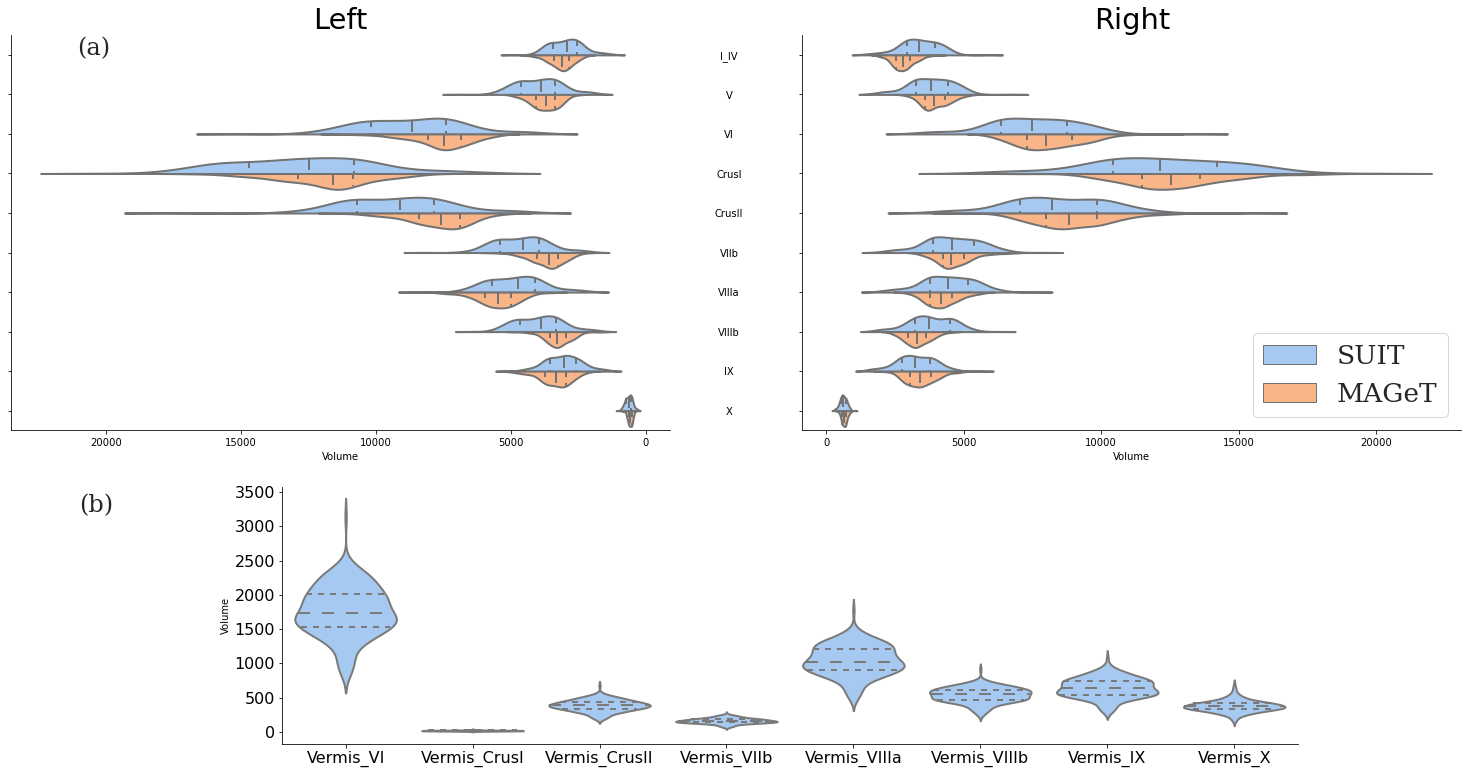

In [3]:
# distribution plot for all the suit and maget
figure_size=(26, 16); 
FONT_SCALE=2.4;
legend_font_size=24
save_fig=1

lobule_list = ['I_IV', 'V', 'VI', 'CrusI', 'CrusII', 'VIIb', 'VIIIa', 'VIIIb', 'IX', 'X'];
dis_df=data_df.copy()

def pivot_cere_df(df, col_list, loc_str, pipeline_str):
    # creat melted dataframe (sub,roi,loc,vol,pipeline) from visualization from raw dataframe (sub*ROI)
    df.columns = col_list; 
    df.loc[:,'sub']=df.index;
    df = pd.melt(df, id_vars='sub', value_vars=col_list, var_name='Lobule', value_name='Volume');
    df.loc[:,'Hemisphere']=loc_str; df.loc[:,'Pipeline']=pipeline_str;
    return df.copy()

suit_l_df_ = dis_df.loc[:, SUIT_l_labels[:length_lobule_list]].copy(); 
suit_l_df_ = pivot_cere_df(suit_l_df_, lobule_list, 'Left', 'SUIT')
suit_r_df_ = dis_df.loc[:, SUIT_r_labels[:length_lobule_list]].copy(); 
suit_r_df_ = pivot_cere_df(suit_r_df_, lobule_list, 'Right', 'SUIT')
suit_v_df_ = dis_df.loc[:, SUIT_v_labels].copy(); 
suit_v_df_ = pivot_cere_df(suit_v_df_, SUIT_v_labels, 'Vermis', 'SUIT')

maget_l_df_ = dis_df.loc[:, MAGeT_l_labels].copy(); 
maget_l_df_ = pivot_cere_df(maget_l_df_, lobule_list, 'Left', 'MAGeT')
maget_r_df_ = dis_df.loc[:, MAGeT_r_labels].copy(); 
maget_r_df_ = pivot_cere_df(maget_r_df_, lobule_list, 'Right', 'MAGeT')

lobule_df = pd.concat([suit_l_df_, suit_r_df_, maget_l_df_, maget_r_df_])
#lobule_df['Volume']=np.log(lobule_df['Volume'])

## vis
f1 = plt.figure(figsize=figure_size, facecolor='w', edgecolor='lightgray')
gs = f1.add_gridspec(2, 2)
ax1 = f1.add_subplot(gs[0, 0])
ax2 = f1.add_subplot(gs[0, 1])
ax3 = f1.add_subplot(gs[1, :])

# Fig. a
sns.set_theme(style="whitegrid", palette="pastel", font_scale=FONT_SCALE)
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
sns.violinplot(data=lobule_df[lobule_df['Hemisphere']=='Left'], x="Volume", y="Lobule", hue="Pipeline",
               split=True, inner="quartile",  scale='count', bw='silverman', orient='h',
               ax=ax1, linewidth=2, saturation=0.9)
ax1.invert_xaxis()
ax1.get_legend().remove()
ax1.get_xaxis().set_visible(True)
ax1.set(yticklabels=[])
ax1.set(ylabel=None)
ax1.set_title('Left',fontsize='medium')
pos1 = ax1.get_position()
ax1.set_position([pos1.x0, pos1.y0,  pos1.width, pos1.height])
#sub_figure index
ax1.text(0.1, 0.95, '(a)', transform=ax1.transAxes, fontsize=legend_font_size)
# Fig. b
sns.set_theme(style="whitegrid", palette="pastel", font_scale=FONT_SCALE)
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
sns.despine();
sns.violinplot(data=lobule_df[lobule_df['Hemisphere']=='Right'], x="Volume", y="Lobule", hue="Pipeline",
               split=True, inner="quartile",  scale='count', bw='silverman', orient='h', 
               ax=ax2, linewidth=2, saturation=0.9)
ax2.get_yaxis().set_visible(True)
ax2.get_xaxis().set_visible(True)
ax2.set_title('Right',fontsize='medium')
ax2.set(ylabel=None)
ax2.legend(loc='lower right')
# ceter y ticklabels
for tick in ax2.yaxis.get_majorticklabels():
    tick.set_horizontalalignment('center')
    pos_tmp=tick.get_position()
    tick.set_position((pos_tmp[0]-0.1,pos_tmp[1]))
    
# Fig. c
sns.set_theme(style="whitegrid", palette="pastel", font_scale=FONT_SCALE-1)
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
sns.despine();
sns.violinplot(data=suit_v_df_, y="Volume", x="Lobule",
               inner="quartile",  scale='width', bw='silverman', orient='v', 
               ax=ax3, linewidth=2, color=sns.color_palette("pastel")[0], saturation=0.9)
ax3.get_yaxis().set_visible(True)
ax3.set(xlabel=None)
ax3.tick_params(axis='both', which='major', labelsize=16)
pos3 = ax3.get_position()
ax3.set_position([pos3.x0+0.145, pos3.y0+0.14,  pos3.width*0.7, pos3.height*0.65])
ax3.text(-0.2, 0.9, '(b)', transform=ax3.transAxes, fontsize=legend_font_size)
if save_fig: print('saving...'); f1.savefig("Fig2-lobule_distr.jpg", dpi=300, bbox_inches='tight', pad_inches=0.1)

saving...
saving...
saving...
saving...


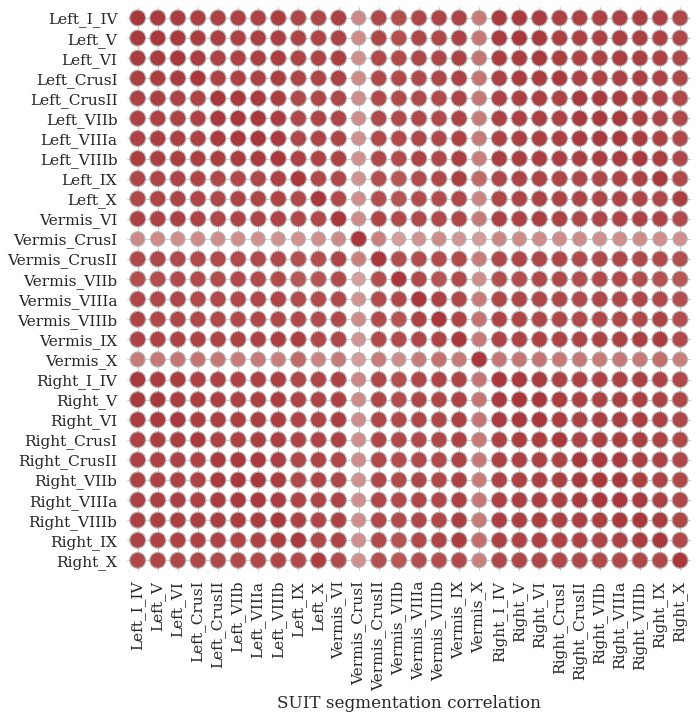

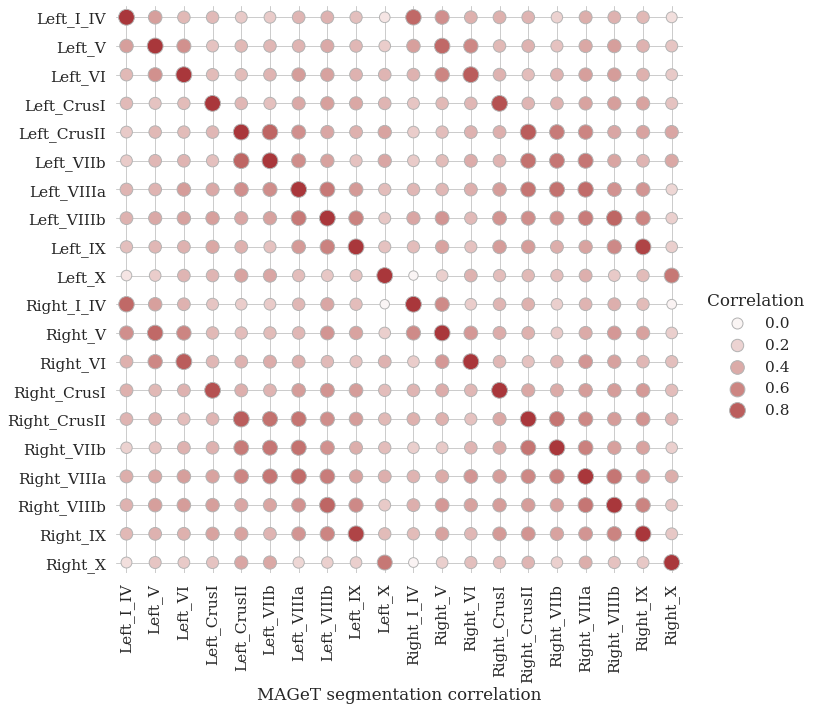

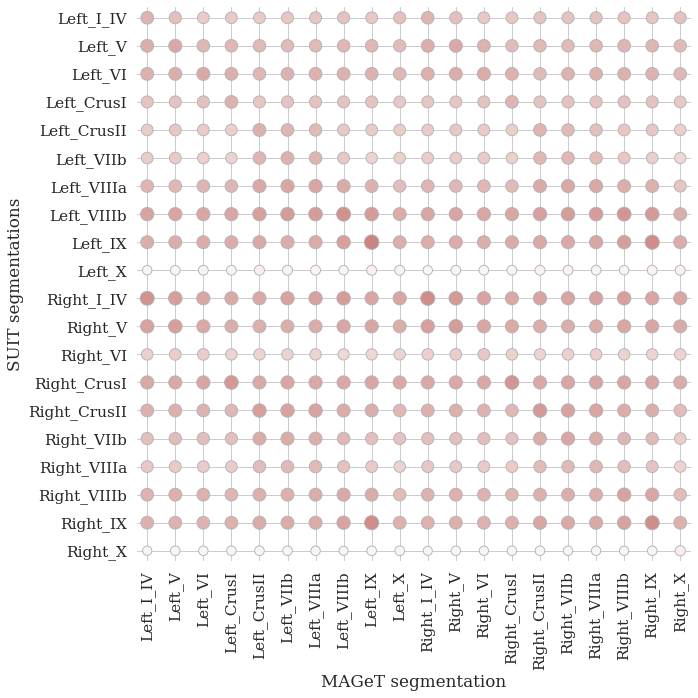

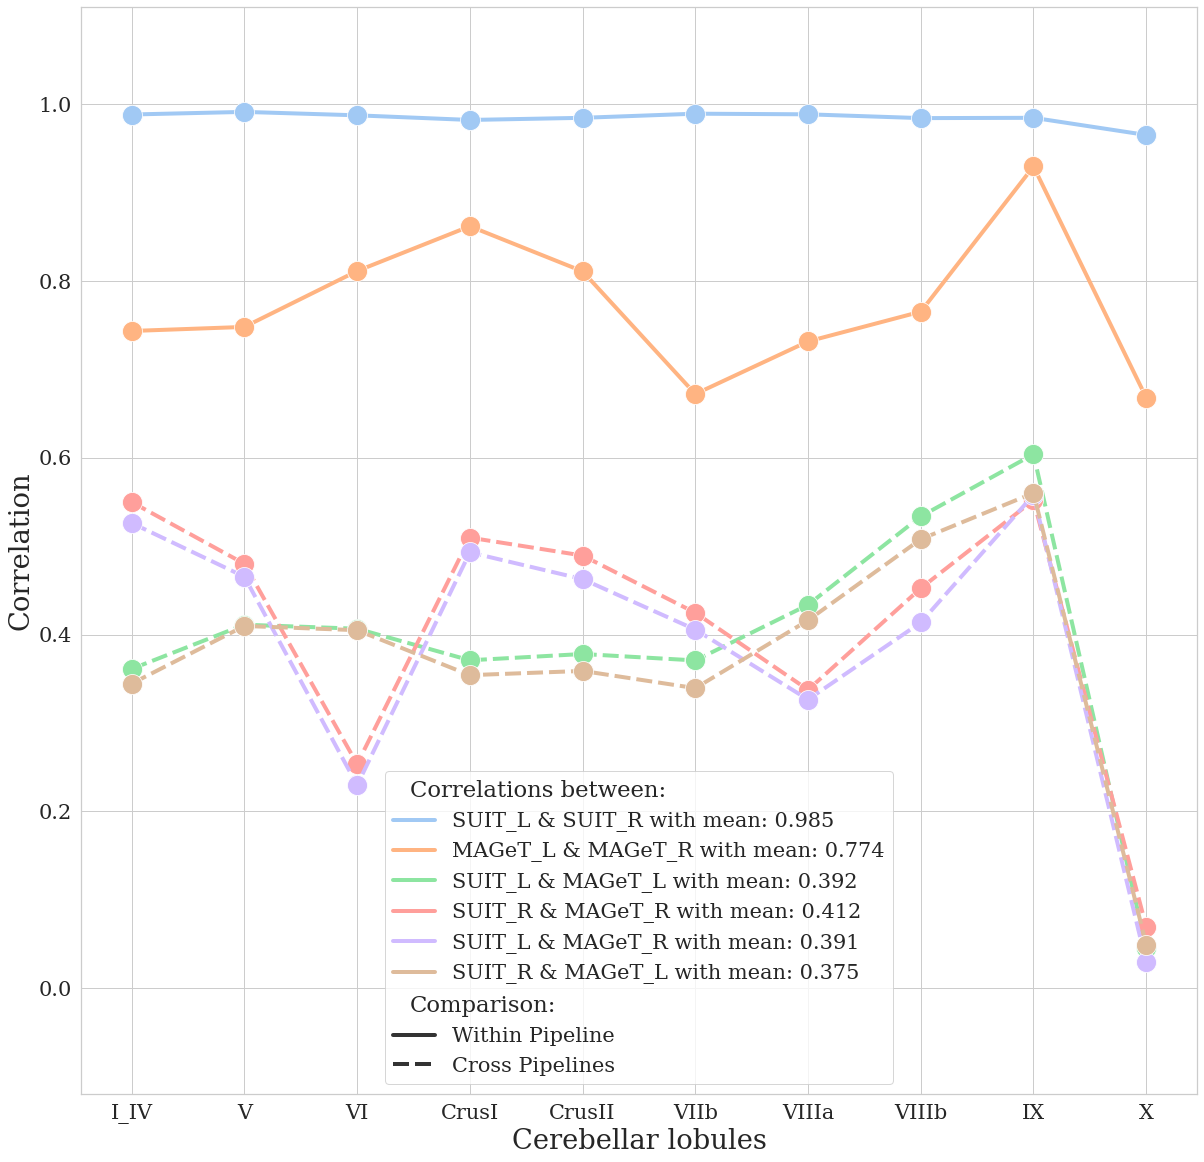

In [4]:
# correlation plot for all the suit and maget results
# distribution plot for all the suit and maget
figure_size=(20, 20); 
FONT_SCALE=1.4;
save_fig=1

lobule_list = ['I_IV', 'V', 'VI', 'CrusI', 'CrusII', 'VIIb', 'VIIIa', 'VIIIb', 'IX', 'X'];
SUIT_l_labels_= SUIT_l_labels[:length_lobule_list]; SUIT_r_labels_=SUIT_r_labels[:length_lobule_list];
suit_labels=SUIT_l_labels_+SUIT_r_labels_;

vis_df=data_df.copy()
# prepare data
suit_df_ = vis_df.loc[:,SUIT_l_labels_+SUIT_v_labels+SUIT_r_labels_].copy()
maget_df_ = vis_df.loc[:,MAGeT_l_labels+MAGeT_r_labels].copy()
sm_df_ = vis_df.loc[:,SUIT_l_labels_+SUIT_r_labels_+MAGeT_l_labels+MAGeT_r_labels].copy()

# Fig. a,b,c Inner correlatoin
suit_corr_df =suit_df_.corr(); suit_corr_long_df = suit_corr_df.stack().reset_index(name="Correlation")
maget_corr_df=maget_df_.corr(); 
maget_corr_df.index=suit_labels; maget_corr_df.columns=suit_labels;
maget_corr_long_df = maget_corr_df.stack().reset_index(name="Correlation")

# cross correlation
sm_corr_df_ = sm_df_.corr();
sm_cross_corr_df_ = sm_corr_df_.iloc[0:length_lobule_list*2,length_lobule_list*2:];
sm_cross_corr_df_.index=suit_labels; sm_cross_corr_df_.columns=suit_labels;
sm_cross_corr_long_df_ = sm_cross_corr_df_.stack().reset_index(name="Correlation")


# Fig.d: cross correlation lines
sl_sr_ = np.diag(suit_corr_df, length_lobule_list+len(SUIT_v_labels));
sl_sr_df= pd.DataFrame({'Correlation':sl_sr_, 'Lobules':lobule_list}); 
sl_sr_df['Correlations between:']='SUIT_L & SUIT_R with mean: '+str(round(np.mean(sl_sr_), 3));
sl_sr_df['Comparison:']='Within Pipeline'
ml_mr_ = np.diag(maget_corr_df, length_lobule_list);
ml_mr_df= pd.DataFrame({'Correlation':ml_mr_, 'Lobules':lobule_list}); 
ml_mr_df['Correlations between:']='MAGeT_L & MAGeT_R with mean: '+str(round(np.mean(ml_mr_), 3));
ml_mr_df['Comparison:']='Within Pipeline'
sl_ml_ = np.diag(sm_cross_corr_df_)[:length_lobule_list]; 
sl_ml_df= pd.DataFrame({'Correlation':sl_ml_, 'Lobules':lobule_list}); 
sl_ml_df['Correlations between:']='SUIT_L & MAGeT_L with mean: '+str(round(np.mean(sl_ml_), 3));
sl_ml_df['Comparison:']='Cross Pipelines'
sr_mr_ = np.diag(sm_cross_corr_df_)[length_lobule_list:];
sr_mr_df= pd.DataFrame({'Correlation':sr_mr_, 'Lobules':lobule_list}); 
sr_mr_df['Correlations between:']='SUIT_R & MAGeT_R with mean: '+str(round(np.mean(sr_mr_), 3));
sr_mr_df['Comparison:']='Cross Pipelines'
sl_mr_ = np.diag(sm_cross_corr_df_, length_lobule_list);
sl_mr_df= pd.DataFrame({'Correlation':sl_mr_, 'Lobules':lobule_list}); 
sl_mr_df['Correlations between:']='SUIT_L & MAGeT_R with mean: '+str(round(np.mean(sl_mr_), 3));
sl_mr_df['Comparison:']='Cross Pipelines'
sr_ml_ = np.diag(sm_cross_corr_df_, -length_lobule_list);
sr_ml_df= pd.DataFrame({'Correlation':sr_ml_, 'Lobules':lobule_list}); 
sr_ml_df['Correlations between:']='SUIT_R & MAGeT_L with mean: '+str(round(np.mean(sr_ml_), 3));
sr_ml_df['Comparison:']='Cross Pipelines'

sm_cros_corr_vis_df = pd.concat([sl_sr_df, ml_mr_df, sl_ml_df, sr_mr_df, sl_mr_df, sr_ml_df])

## vis

# Fig2. a
sns.set_theme(style="whitegrid", palette="pastel", font_scale=FONT_SCALE)
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
g1 = sns.relplot(
    data=suit_corr_long_df,
    x="level_0", y="level_1", hue="Correlation", size="Correlation",
    palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
    height=10, sizes=(50, 250), size_norm=(-0.2, 0.8), legend=False
)

# Tweak the figure
g1.set(xlabel="", ylabel="", aspect="equal")
g1.despine(left=True, bottom=True)
g1.ax.margins(.02)
g1.set_xlabels('SUIT segmentation correlation')
for label in g1.ax.get_xticklabels():
    label.set_rotation(90)
g1.tight_layout()
if save_fig: print('saving...'); g1.savefig("Fig2-SUIT_corr.jpg", dpi=300, bbox_inches='tight', pad_inches=0.1);

# Fig2. b
sns.set_theme(style="whitegrid", palette="pastel", font_scale=FONT_SCALE)
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
g2 = sns.relplot(
    data=maget_corr_long_df,
    x="level_0", y="level_1", hue="Correlation", size="Correlation",
    palette="vlag", hue_norm=(-1, 1), edgecolor=".7", legend='auto',
    height=10, sizes=(50, 250), size_norm=(-0.2, 0.8),
)

# Tweak the figure
g2.set(xlabel="", ylabel="", aspect="equal")
g2.despine(left=True, bottom=True)
g2.ax.margins(.02)
g2.set_xlabels('MAGeT segmentation correlation')
#g2.legend.
for label in g2.ax.get_xticklabels():
    label.set_rotation(90)
for artist in g2.legend.legendHandles:
    artist.set_edgecolor(".7")
g2.tight_layout()
if save_fig: print('saving...'); g2.savefig("Fig2-MAGeT_corr.jpg", dpi=300, bbox_inches='tight', pad_inches=0.1);

# Fig2. c
sns.set_theme(style="whitegrid", palette="pastel", font_scale=FONT_SCALE)
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
g3 = sns.relplot(
    data=sm_cross_corr_long_df_,
    x="level_0", y="level_1", hue="Correlation", size="Correlation",
    palette="vlag", hue_norm=(-1, 1), edgecolor=".7", legend=False,
    height=10, sizes=(50, 250), size_norm=(-0.2, 0.8),
)
# Tweak the figure
g3.set(xlabel="", ylabel="", aspect="equal")
g3.despine(left=True, bottom=True)
g3.ax.margins(.02)
g3.set_ylabels('SUIT segmentations')
g3.set_xlabels('MAGeT segmentation')
#g2.legend.
for label in g3.ax.get_xticklabels():
    label.set_rotation(90)
g3.tight_layout()
if save_fig: print('saving...'); g3.savefig("Fig2-SUIT-MAGeT_cross-corr.jpg", dpi=300, bbox_inches='tight', pad_inches=0.1);

# Fig2. d
sns.set_theme(style="whitegrid", palette="pastel", font_scale=FONT_SCALE+0.5)
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
f2, ax4 = plt.subplots(figsize=figure_size, facecolor='w', edgecolor='lightgray') 
sns.lineplot(data=sm_cros_corr_vis_df, y="Correlation", x="Lobules", hue="Correlations between:", #size="Correlation", style="Correlation between:", 
             style='Comparison:', style_order=['Within Pipeline','Cross Pipelines'], marker='o', markersize=20, lw=4,
             ax=ax4)
ax4.set(ylim=[-0.12,1.11])
ax4.set_xlabel('Cerebellar lobules', fontsize='large')
ax4.set_ylabel('Correlation', fontsize='large')
for legobj in ax4.legend_.legendHandles:
    legobj.set_linewidth(4)
    
if save_fig: print('saving...'); f2.savefig("Fig2-SUIT-MAGeT_cross-corr_line.jpg", dpi=300, bbox_inches='tight', pad_inches=0.1);


In [5]:
# MAGeT results for MNI cohort
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import glm
import statsmodels.stats as sts
from utils_et_biomarker.utils import glm_test, rep_model

# basic settings
alpha_=0.05

glm_df=data_df.copy()
tar_list_suit = ['Left_CrusI', 'Left_CrusII', 'Right_CrusI','Right_CrusII']
tar_list_maget = ['L_Crus_I', 'L_Crus_II', 'R_Crus_I', 'R_Crus_II']


# MAGeT test
alpha_=0.05
glm_df=data_df.copy()
print("Sample sizes for ET/NC: ")
print('\t',glm_df[glm_df['group']=='ET'].shape[0], ' / ',glm_df[glm_df['group']=='NC'].shape[0])
print("tested ROIs:")
print('\t',', '.join(tar_list_suit))

print("\nGLM for MAGeT cerebellum volumetry (age/sex/eTIV) on matched cohort:")
# 1.GLM for cerebellum volumetry with covariates:  age/sex/cohort/group/eTIV
covariate_model_eTIV_str = '~age+C(sex, Treatment(reference="F"))+eTIV+C(cohort, Treatment(reference="MNI"))+C(group, Treatment(reference="NC"))';
covariate_dict_etiv = glm_test(glm_df, tar_list_maget, covariate_model_eTIV_str);
rep_model(covariate_dict_etiv, {'name':'significant','col_name':'C(group, Treatment(reference="NC"))[T.ET]','th':alpha_});

# 2. GLM for cerebellum volumetry with covariates: age/sex/cohort/group/cerebellumVol.
print("\nGLM for MAGeT cerebellum volumetry (age/sex/cerebellumVol) on matched cohort:")
covariate_model_cere_str = '~age+C(sex, Treatment(reference="F"))+cerebellumVol+C(cohort, Treatment(reference="MNI"))+C(group, Treatment(reference="NC"))';
covariate_dict_cere = glm_test(glm_df, tar_list_maget, covariate_model_cere_str);
rep_model(covariate_dict_cere, {'name':'significant','col_name':'C(group, Treatment(reference="NC"))[T.ET]','th':alpha_});

# Recall SUIT test results:
print("\nGLM for SUIT cerebellum volumetry (age/sex/eTIV) on matched cohort:")
# 1.GLM for cerebellum volumetry with covariates:  age/sex/cohort/group/eTIV
covariate_model_eTIV_str = '~age+C(sex, Treatment(reference="F"))+eTIV+C(cohort, Treatment(reference="MNI"))+C(group, Treatment(reference="NC"))';
covariate_dict_etiv = glm_test(glm_df, tar_list_suit, covariate_model_eTIV_str);
rep_model(covariate_dict_etiv, {'name':'significant','col_name':'C(group, Treatment(reference="NC"))[T.ET]','th':alpha_});

# 2. GLM for cerebellum volumetry with covariates: age/sex/cohort/group/cerebellumVol.
print("\nGLM for SUIT cerebellum volumetry (age/sex/cerebellumVol) on matched cohort:")
covariate_model_cere_str = '~age+C(sex, Treatment(reference="F"))+cerebellumVol+C(cohort, Treatment(reference="MNI"))+C(group, Treatment(reference="NC"))';
covariate_dict_cere = glm_test(glm_df, tar_list_suit, covariate_model_cere_str);
rep_model(covariate_dict_cere, {'name':'significant','col_name':'C(group, Treatment(reference="NC"))[T.ET]','th':alpha_});

Sample sizes for ET/NC: 
	 35  /  177
tested ROIs:
	 Left_CrusI, Left_CrusII, Right_CrusI, Right_CrusII

GLM for MAGeT cerebellum volumetry (age/sex/eTIV) on matched cohort:
L_Crus_I : no significant result with p= 0.14563057902702298
L_Crus_II : no significant result with p= 0.8356119668445912
R_Crus_I : no significant result with p= 0.6846516639108093
R_Crus_II : no significant result with p= 0.8516562365634724

GLM for MAGeT cerebellum volumetry (age/sex/cerebellumVol) on matched cohort:
L_Crus_I : no significant result with p= 0.2086045160145258
L_Crus_II : no significant result with p= 0.7622423731038767
R_Crus_I : no significant result with p= 0.9698250512538341
R_Crus_II : no significant result with p= 0.7646641063934347

GLM for SUIT cerebellum volumetry (age/sex/eTIV) on matched cohort:
Left_CrusI : no significant result with p= 0.11819028805797913
Left_CrusII : no significant result with p= 0.15122528945686017
Right_CrusI : no significant result with p= 0.12410690345382408
Ri

,Left_I_IV,Left_V,Left_VI,Left_CrusI,Left_CrusII,Left_VIIb,Left_VIIIa,Left_VIIIb,Left_IX,Left_X,...,R_I_IV,R_V,R_VI,R_Crus_I,R_Crus_II,R_VIIB,R_VIIIA,R_VIIIB,R_IX,R_X
Left_I_IV,1.000000,0.982452,0.970506,0.953836,0.947013,0.948965,0.952291,0.961004,0.925529,0.927165,...,0.526292,0.448895,0.216491,0.419046,0.375707,0.299882,0.257166,0.365614,0.367536,-0.025335
Left_V,0.982452,1.000000,0.983181,0.961845,0.954851,0.951845,0.953389,0.960080,0.930211,0.933815,...,0.467451,0.465564,0.230003,0.415937,0.381757,0.316459,0.246257,0.376609,0.365613,0.002627
Left_VI,0.970506,0.983181,1.000000,0.969993,0.949950,0.951935,0.955183,0.962444,0.934460,0.934712,...,0.424740,0.410979,0.229750,0.424997,0.361650,0.310761,0.238754,0.367949,0.363728,0.000137
Left_CrusI,0.953836,0.961845,0.969993,1.000000,0.944988,0.948843,0.952873,0.955616,0.930424,0.937021,...,0.417422,0.390458,0.204797,0.493076,0.336786,0.296900,0.234791,0.356934,0.372307,0.000314
Left_CrusII,0.947013,0.954851,0.949950,0.944988,1.000000,0.986585,0.980025,0.961139,0.918947,0.927759,...,0.419338,0.382458,0.201495,0.409052,0.462847,0.399737,0.311845,0.375674,0.402610,0.018671
Left_VIIb,0.948965,0.951845,0.951935,0.948843,0.986585,1.000000,0.995063,0.972644,0.914358,0.932507,...,0.438363,0.383232,0.208713,0.423254,0.451157,0.405765,0.323556,0.379908,0.396207,0.007986
Left_VIIIa,0.952291,0.953389,0.955183,0.952873,0.980025,0.995063,1.000000,0.980083,0.923356,0.934056,...,0.446430,0.393615,0.205350,0.421699,0.440577,0.388805,0.326636,0.384302,0.401925,0.000289
Left_VIIIb,0.961004,0.960080,0.962444,0.955616,0.961139,0.972644,0.980083,1.000000,0.949083,0.939224,...,0.471364,0.429436,0.182492,0.416028,0.397531,0.340958,0.288700,0.413778,0.440860,-0.034535
Left_IX,0.925529,0.930211,0.934460,0.930424,0.918947,0.914358,0.923356,0.949083,1.000000,0.908027,...,0.429610,0.425328,0.184519,0.425915,0.388044,0.304610,0.249243,0.397439,0.558130,0.011445
Left_X,0.927165,0.933815,0.934712,0.937021,0.927759,0.932507,0.934056,0.939224,0.908027,1.000000,...,0.432483,0.388536,0.198483,0.412579,0.341025,0.282504,0.210270,0.316232,0.371119,0.029298


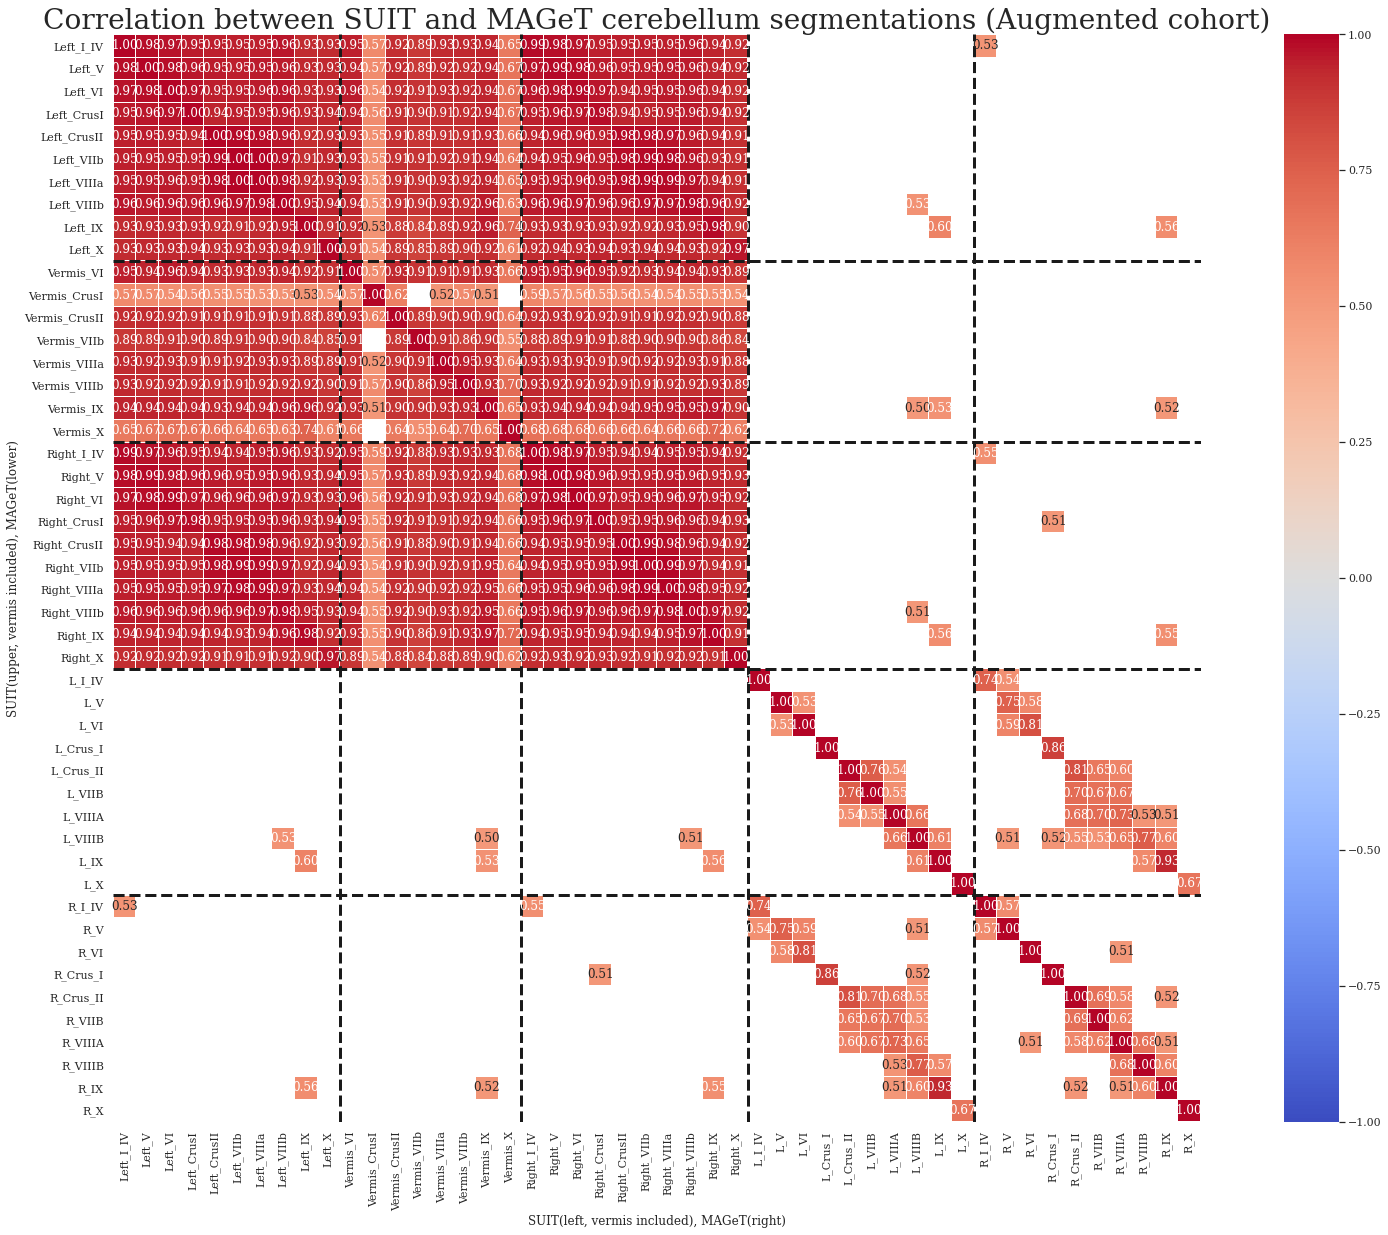

In [6]:
# Heatmap of full correlation between SUIT and MAGeT measures (Augmented NC)
# vis config
sns.set_theme(style="whitegrid", palette="pastel", font_scale=1)
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})

C_MAP='coolwarm'; TH=0.5
# select data
vis_df=data_df.copy()
vis_df=vis_df.loc[:,SUIT_l_labels[:length_lobule_list]+SUIT_v_labels+SUIT_r_labels[:length_lobule_list]+MAGeT_l_labels+MAGeT_r_labels]
# data proc
corr_=vis_df.corr()
mask_=corr_.where(np.abs(corr_)>TH, True).copy()
mask_=mask_.applymap(lambda x: False if isinstance(x, float) else True, na_action='ignore')

# Draw a heatmap with the numeric values in each cell
f1, ax = plt.subplots(figsize=(30, 20))
sns.heatmap(corr_, ax=ax, annot=True, fmt=".2f", mask=mask_,
            vmax=1, vmin=-1, cmap=C_MAP, square=True, linewidths=.05)
ax.set_ylabel("SUIT(upper, vermis included), MAGeT(lower)")
ax.set_xlabel("SUIT(left, vermis included), MAGeT(right)")
ax.set_title('Correlation between SUIT and MAGeT cerebellum segmentations (Augmented cohort)', fontsize=28)
line_pos=[length_lobule_list,length_lobule_list+len(SUIT_v_labels),length_lobule_list*2+len(SUIT_v_labels),length_lobule_list*3+len(SUIT_v_labels)]
for x in line_pos:
    plt.axhline(x, ls='--',c='k', lw=3); plt.axvline(x, ls='--',c='k', lw=3)
f1.savefig("Augmented-Cohort_SUIT-MAGeT_comp.jpg")
display(corr_)

(51, 54)


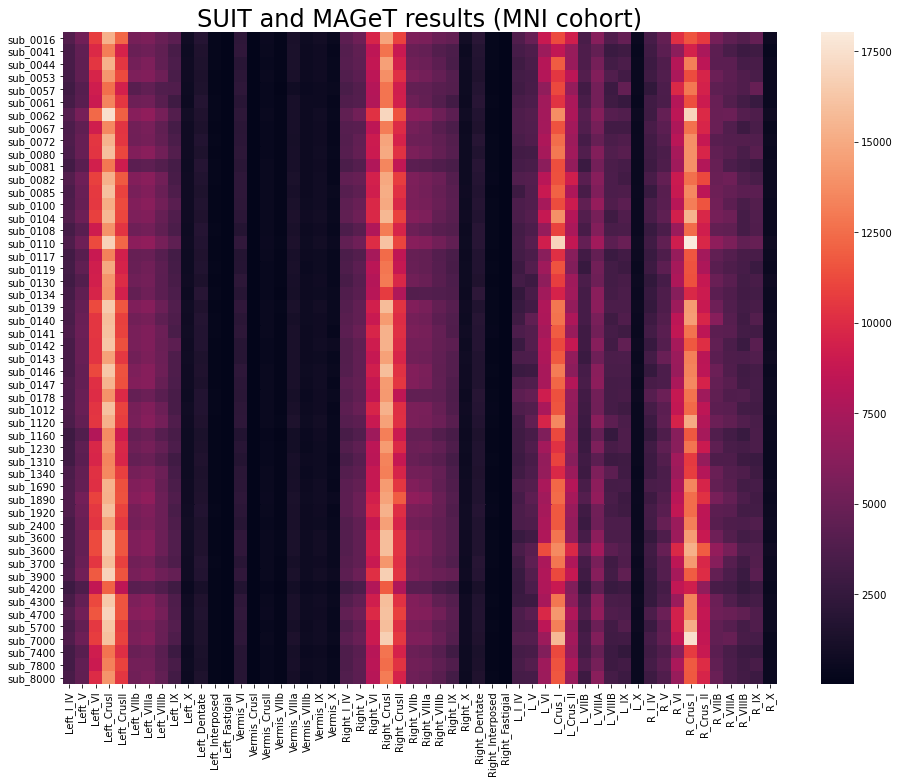

In [6]:
# visual inspection: Heatmap of SUIT and MAGeT measures
vis_df=data_df.loc[data_df['cohort']=='MNI'].copy()
vis_df=vis_df.loc[:,SUIT_l_labels+SUIT_v_labels+SUIT_r_labels+MAGeT_l_labels+MAGeT_r_labels]
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(vis_df, ax=ax)
ax.set_title('SUIT and MAGeT results (MNI cohort)', fontsize=24)
print(vis_df.shape)

(212, 54)


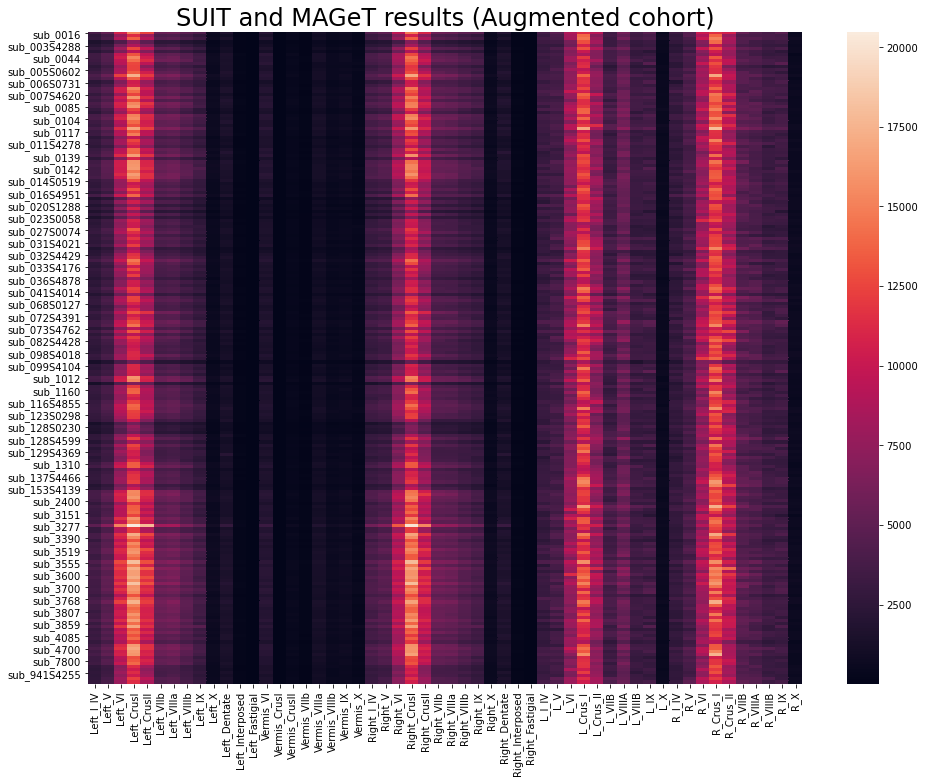

In [7]:
# Heatmap of results between SUIT and MAGeT measures (intercept)
vis_df=data_df.loc[:,SUIT_l_labels+SUIT_v_labels+SUIT_r_labels+MAGeT_l_labels+MAGeT_r_labels].copy()
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(vis_df, ax=ax)
ax.set_title('SUIT and MAGeT results (Augmented cohort)', fontsize=24)
print(vis_df.shape)